In [59]:
import numpy as np
import pandas as pd
import pulp

from sklearn.linear_model import Ridge
from sklearn.preprocessing import MultiLabelBinarizer

In [61]:
# ==========================================
# MODEL SETTINGS
# ==========================================
RATING_CAP = 8.0
LINEUP_SIZE = 4
ALPHA = 10.0
MIN_STINT_THRESHOLD = 80

#Modify Data Path
PLAYER_DATA_PATH = "/Users/eileenerkan/Desktop/433/player_data.csv"
STINT_DATA_PATH  = "/Users/eileenerkan/Desktop/433/stint_data.csv"

In [63]:
# ==========================================
# SIMPLE COACH PROMPTS
# ==========================================
def prompt_required_text(prompt):
    while True:
        s = input(f"{prompt}: ").strip()
        if s:
            return s
        print("Please enter a value.")

def prompt_list(prompt):
    s = input(f"{prompt} (comma-separated, blank = none): ").strip()
    if not s:
        return []
    return [x.strip() for x in s.split(",") if x.strip()]

def prompt_float(prompt, default):
    s = input(f"{prompt} [{default}]: ").strip()
    return float(s) if s else float(default)

In [65]:
# ==========================================
# CORE FUNCTIONS
# ==========================================
def get_focal_players(df, focal_team):
    is_home = (df["h_team"] == focal_team)
    home_cols = ["home1", "home2", "home3", "home4"]
    away_cols = ["away1", "away2", "away3", "away4"]

    home_lists = df[home_cols].values.tolist()
    away_lists = df[away_cols].values.tolist()

    return pd.Series(
        [home_lists[i] if is_home.iloc[i] else away_lists[i] for i in range(len(df))],
        index=df.index
    )


def solve_lineup_optimization(coefs, rating_map):
    df = pd.DataFrame({"player": coefs.index, "value": coefs.values})
    df["rating"] = df["player"].map(rating_map)
    df = df.dropna(subset=["rating"])

    prob = pulp.LpProblem("Lineup_Optimization", pulp.LpMaximize)
    x = {p: pulp.LpVariable(f"x_{p}", 0, 1, cat="Binary") for p in df["player"]}

    prob += pulp.lpSum(df.loc[df["player"] == p, "value"].values[0] * x[p] for p in df["player"])
    prob += pulp.lpSum(x[p] for p in df["player"]) == LINEUP_SIZE
    prob += pulp.lpSum(df.loc[df["player"] == p, "rating"].values[0] * x[p] for p in df["player"]) <= RATING_CAP

    prob.solve(pulp.PULP_CBC_CMD(msg=False))

    selected = [p for p in df["player"] if pulp.value(x[p]) > 0.5]
    return df[df["player"].isin(selected)].sort_values("value", ascending=False)


In [67]:
# ==========================================
# DATA PREP
# ==========================================
def load_and_prepare():
    players = pd.read_csv(PLAYER_DATA_PATH)
    stints = pd.read_csv(STINT_DATA_PATH)

    rating_map = dict(zip(players["player"], players["rating"]))

    stints["h_goals"] = pd.to_numeric(stints["h_goals"], errors="coerce")
    stints["a_goals"] = pd.to_numeric(stints["a_goals"], errors="coerce")
    stints["minutes"] = pd.to_numeric(stints["minutes"], errors="coerce")

    stints["total_goals"] = stints["h_goals"] + stints["a_goals"]
    stints["goal_rate"] = stints["total_goals"] / stints["minutes"].replace(0, np.nan)

    stints = stints.dropna(subset=["goal_rate", "h_team", "a_team", "minutes"])
    return stints, rating_map


def filter_matchup(stints, focal_team, opponent):
    return stints[
        ((stints["h_team"] == focal_team) & (stints["a_team"] == opponent)) |
        ((stints["a_team"] == focal_team) & (stints["h_team"] == opponent))
    ].copy()


def filter_focal_aggregated(stints, focal_team):
    return stints[(stints["h_team"] == focal_team) | (stints["a_team"] == focal_team)].copy()

In [69]:
# ==========================================
# MODEL + COACH ADJUSTMENTS
# ==========================================
def fit_ridge(df, focal_team):
    df = df.copy()
    df["players_on_court"] = get_focal_players(df, focal_team)

    mlb = MultiLabelBinarizer(sparse_output=True)
    X = mlb.fit_transform(df["players_on_court"])
    y = df["goal_rate"].values

    model = Ridge(alpha=ALPHA).fit(X, y)
    return pd.Series(model.coef_, index=mlb.classes_)


def apply_coach_constraints(coefs, unavailable, tired, penalty):
    c = coefs.copy()
    c = c.drop(labels=unavailable, errors="ignore")

    for p in tired:
        if p in c.index:
            c.loc[p] *= (1 - penalty)
    return c

In [71]:
# ==========================================
# MAIN RUN
# ==========================================
def run():
    print("\n=== Coach Lineup Tool ===\n")

    # REQUIRED (no defaults)
    focal_team = prompt_required_text("Focal team")
    opponent   = prompt_required_text("Opponent")

    # Coach inputs (optional lists + penalty has a default)
    unavailable = prompt_list("Unavailable players")
    tired       = prompt_list("Fatigued players")
    fatigue_penalty = prompt_float("Fatigue penalty", 0.30)

    stints, rating_map = load_and_prepare()
    matchup_df = filter_matchup(stints, focal_team, opponent)
    n_stints = len(matchup_df)

    if n_stints < MIN_STINT_THRESHOLD:
        print("\nNOT ENOUGH STINTS")
        print(f"Focal team: {focal_team}")
        print(f"Opponent: {opponent}")
        print(f"Matchup stints: {n_stints} (< {MIN_STINT_THRESHOLD})")
        print("Using aggregated focal-team model\n")
        train_df = filter_focal_aggregated(stints, focal_team)
        model_used = "Aggregated focal-team"
    else:
        train_df = matchup_df
        model_used = "Matchup-specific"

    base_coefs = fit_ridge(train_df, focal_team)

    # Baseline (no constraints)
    baseline = solve_lineup_optimization(base_coefs, rating_map)

    # Coach constraints
    adj_coefs = apply_coach_constraints(base_coefs, unavailable, tired, fatigue_penalty)
    constrained = solve_lineup_optimization(adj_coefs, rating_map)

    def lineup_str(df):
        return ", ".join(df["player"].tolist())

    # Build a CLEAN results table with consistent columns (no NaNs)
    results = pd.DataFrame([
        {
            "Scenario": "Baseline",
            "Focal Team": focal_team,
            "Opponent": opponent,
            "Model Used": model_used,
            "Matchup Stints": n_stints,
            "Unavailable": "-",
            "Tired": "-",
            "Fatigue Penalty": "-",
            "Lineup": lineup_str(baseline),
            "Total Value": round(float(baseline["value"].sum()), 4),
            "Total Rating": round(float(baseline["rating"].sum()), 2),
        },
        {
            "Scenario": "Coach constraints",
            "Focal Team": focal_team,
            "Opponent": opponent,
            "Model Used": model_used,
            "Matchup Stints": n_stints,
            "Unavailable": ", ".join(unavailable) if unavailable else "-",
            "Tired": ", ".join(tired) if tired else "-",
            "Fatigue Penalty": fatigue_penalty,
            "Lineup": lineup_str(constrained),
            "Total Value": round(float(constrained["value"].sum()), 4),
            "Total Rating": round(float(constrained["rating"].sum()), 2),
        },
    ])

    # Pretty printing (works great in notebook output)
    # Option A: Jupyter display (best)
    try:
        from IPython.display import display
        display(results)
    except Exception:
        pass

    return results


# ==========================================
# RUN SCRIPT
# ==========================================
if __name__ == "__main__":
    df = run()



=== Coach Lineup Tool ===



Focal team:  Canada
Opponent:  Sweden
Unavailable players (comma-separated, blank = none):  Canada_p2
Fatigued players (comma-separated, blank = none):  Canada_p4
Fatigue penalty [0.3]:  0.3


,Scenario,Focal Team,Opponent,Model Used,Matchup Stints,Unavailable,Tired,Fatigue Penalty,Lineup,Total Value,Total Rating
0,Baseline,Canada,Sweden,Matchup-specific,118,-,-,-,"Canada_p2, Canada_p8, Canada_p1, Canada_p6",1.4634,8.0
1,Coach constraints,Canada,Sweden,Matchup-specific,118,Canada_p2,Canada_p4,0.3,"Canada_p8, Canada_p6, Canada_p11, Canada_p10",0.5381,8.0


In [64]:
#TESTING + VALIDATION

In [75]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd

def build_matchup_xy():
    # Load data
    players = pd.read_csv(PLAYER_DATA_PATH)
    stints = pd.read_csv(STINT_DATA_PATH)

    # Clean stints (same logic as yours)
    stints["total_goals"] = pd.to_numeric(stints["h_goals"]) + pd.to_numeric(stints["a_goals"])
    stints["goal_rate"] = stints["total_goals"] / stints["minutes"].replace(0, np.nan)
    stints = stints.dropna(subset=["goal_rate", "h_team", "a_team"])

    # Filter matchup
    match_df = stints[
        ((stints["h_team"] == FOCAL_TEAM) & (stints["a_team"] == OPPONENT)) |
        ((stints["a_team"] == FOCAL_TEAM) & (stints["h_team"] == OPPONENT))
    ].copy()

    if len(match_df) == 0:
        raise ValueError(f"No stints found for matchup {FOCAL_TEAM} vs {OPPONENT}")

    # Create player lists
    match_df["players_on_court"] = get_focal_players(match_df, FOCAL_TEAM)

    # Build X/y
    mlb = MultiLabelBinarizer(sparse_output=True)
    X = mlb.fit_transform(match_df["players_on_court"])
    y = match_df["goal_rate"].values

    return match_df, X, y, mlb

match_df, X, y, mlb = build_matchup_xy()
print("Matchup stints:", len(match_df))
print("Num focal players (features):", X.shape[1])


Matchup stints: 118
Num focal players (features): 12


In [77]:
alpha_grid = [0.01, 0.1, 1, 5, 10, 25, 50, 100]

coef_results = []
for a in alpha_grid:
    model = Ridge(alpha=a).fit(X, y)
    coefs = pd.Series(model.coef_, index=mlb.classes_)

    coef_results.append({
        "alpha": a,
        "l2_norm": float(np.linalg.norm(coefs.values)),
        "max_abs_coef": float(np.max(np.abs(coefs.values))),
        "mean_abs_coef": float(np.mean(np.abs(coefs.values)))
    })

coef_df = pd.DataFrame(coef_results).sort_values("alpha")
coef_df


,alpha,l2_norm,max_abs_coef,mean_abs_coef
0,0.01,1.534204,0.659496,0.395979
1,0.10,1.527482,0.664620,0.394173
2,1.00,1.472033,0.683785,0.378872
3,5.00,1.288605,0.642905,0.329391
4,10.00,1.119526,0.576714,0.284741
5,25.00,0.808662,0.436779,0.203488
6,50.00,0.556723,0.311754,0.138494
7,100.00,0.344999,0.199014,0.084782


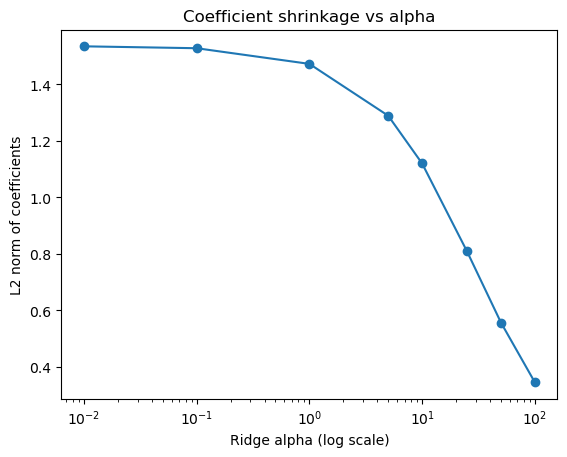

In [79]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(coef_df["alpha"], coef_df["l2_norm"], marker="o")
plt.xscale("log")
plt.xlabel("Ridge alpha (log scale)")
plt.ylabel("L2 norm of coefficients")
plt.title(f"Coefficient shrinkage vs alpha")
plt.show()


In [80]:
top_k = 8

for a in alpha_grid:
    model = Ridge(alpha=a).fit(X, y)
    coefs = pd.Series(model.coef_, index=mlb.classes_).sort_values(key=np.abs, ascending=False)

    print(f"\nalpha = {a} | top {top_k} by |coef|")
    print(coefs.head(top_k))



alpha = 0.01 | top 8 by |coef|
Canada_p2     0.659496
Canada_p9    -0.620704
Canada_p4    -0.605837
Canada_p8     0.592955
Canada_p12   -0.514639
Canada_p1     0.447857
Canada_p10   -0.371350
Canada_p11    0.282358
dtype: float64

alpha = 0.1 | top 8 by |coef|
Canada_p2     0.664620
Canada_p9    -0.620488
Canada_p4    -0.602828
Canada_p8     0.585943
Canada_p12   -0.507826
Canada_p1     0.443195
Canada_p10   -0.366513
Canada_p11    0.281523
dtype: float64

alpha = 1 | top 8 by |coef|
Canada_p2     0.683785
Canada_p9    -0.609881
Canada_p4    -0.576071
Canada_p8     0.539260
Canada_p12   -0.466733
Canada_p1     0.411820
Canada_p10   -0.337779
Canada_p6     0.280958
dtype: float64

alpha = 5 | top 8 by |coef|
Canada_p2     0.642905
Canada_p9    -0.538953
Canada_p4    -0.485938
Canada_p8     0.443520
Canada_p12   -0.401600
Canada_p1     0.344181
Canada_p10   -0.293841
Canada_p6     0.254005
dtype: float64

alpha = 10 | top 8 by |coef|
Canada_p2     0.576714
Canada_p9    -0.465606
Canada_

In [83]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


In [85]:
alpha_grid = [0.01, 0.1, 1, 5, 10, 25, 50, 100]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_results = []

for a in alpha_grid:
    fold_mse = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = Ridge(alpha=a)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        fold_mse.append(mean_squared_error(y_val, y_pred))

    mse_results.append({
        "alpha": a,
        "cv_mse": np.mean(fold_mse),
        "cv_mse_std": np.std(fold_mse)
    })

mse_df = pd.DataFrame(mse_results)
mse_df


,alpha,cv_mse,cv_mse_std
0,0.01,2.723788,0.905639
1,0.10,2.714960,0.905980
2,1.00,2.666657,0.916525
3,5.00,2.605216,0.972375
4,10.00,2.590888,1.023013
5,25.00,2.620319,1.101023
6,50.00,2.681290,1.149753
7,100.00,2.751697,1.182495


In [87]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

alpha_grid = [0.01, 0.1, 1, 5, 10, 25, 50, 100]
n_runs = 50
train_frac = 0.7

bias_var_results = []

rng = np.random.default_rng(42)

for a in alpha_grid:
    preds = []

    for _ in range(n_runs):
        idx = rng.choice(len(y), size=int(train_frac * len(y)), replace=False)
        oob = np.setdiff1d(np.arange(len(y)), idx)

        X_train, y_train = X[idx], y[idx]
        X_test, y_test = X[oob], y[oob]

        model = Ridge(alpha=a)
        model.fit(X_train, y_train)
        preds.append(model.predict(X_test))

    preds = np.array(preds)  # shape: (n_runs, n_test)
    y_test = y_test[:preds.shape[1]]  # align

    mean_pred = preds.mean(axis=0)

    bias_sq = np.mean((mean_pred - y_test) ** 2)
    variance = np.mean(np.var(preds, axis=0))
    total_error = bias_sq + variance

    bias_var_results.append({
        "alpha": a,
        "bias_sq": bias_sq,
        "variance": variance,
        "total_error": total_error
    })

bv_df = pd.DataFrame(bias_var_results)
bv_df


,alpha,bias_sq,variance,total_error
0,0.01,2.281894,0.703951,2.985845
1,0.10,2.973018,0.672960,3.645978
2,1.00,2.167745,0.600833,2.768579
3,5.00,2.305350,0.373999,2.679349
4,10.00,1.987842,0.290006,2.277848
5,25.00,2.450779,0.136067,2.586846
6,50.00,1.145363,0.060035,1.205398
7,100.00,4.328689,0.032236,4.360925


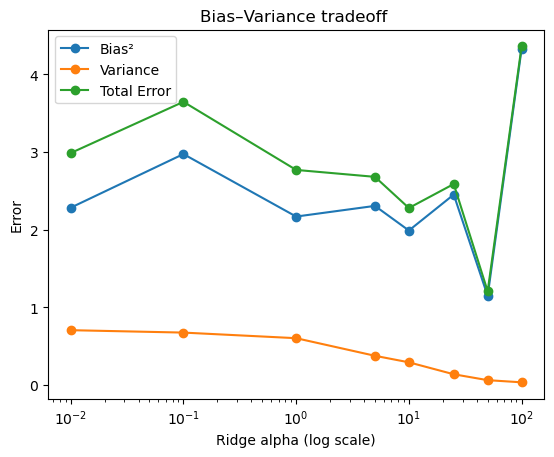

In [89]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(bv_df["alpha"], bv_df["bias_sq"], label="Bias²", marker="o")
plt.plot(bv_df["alpha"], bv_df["variance"], label="Variance", marker="o")
plt.plot(bv_df["alpha"], bv_df["total_error"], label="Total Error", marker="o")

plt.xscale("log")
plt.xlabel("Ridge alpha (log scale)")
plt.ylabel("Error")
plt.title("Bias–Variance tradeoff ")
plt.legend()
plt.show()


In [91]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

alpha = 10
train_sizes = [20, 40, 60, 80, 100]
n_reps = 20

lc_results = []

for n in train_sizes:
    for _ in range(n_reps):
        idx = np.random.choice(len(y), size=n, replace=False)
        oob = np.setdiff1d(np.arange(len(y)), idx)

        X_train, y_train = X[idx], y[idx]
        X_val, y_val = X[oob], y[oob]

        model = Ridge(alpha=alpha).fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        lc_results.append({
            "n_stints": n,
            "train_mse": mean_squared_error(y_train, y_train_pred),
            "val_mse": mean_squared_error(y_val, y_val_pred)
        })

lc_df = pd.DataFrame(lc_results).groupby("n_stints").mean().reset_index()
lc_df


,n_stints,train_mse,val_mse
0,20,1.874195,2.967650
1,40,2.132568,2.778655
2,60,2.129972,2.866223
3,80,2.285443,2.670234
4,100,2.323853,2.467127


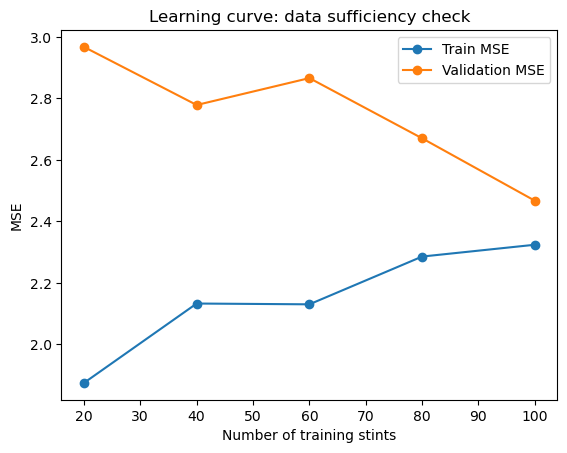

In [93]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(lc_df["n_stints"], lc_df["train_mse"], marker="o", label="Train MSE")
plt.plot(lc_df["n_stints"], lc_df["val_mse"], marker="o", label="Validation MSE")
plt.xlabel("Number of training stints")
plt.ylabel("MSE")
plt.title("Learning curve: data sufficiency check")
plt.legend()
plt.show()


In [95]:
# baseline using full data
base_model = Ridge(alpha=10).fit(X, y)
base_coefs = pd.Series(base_model.coef_, index=mlb.classes_)

stab_results = []

for n in train_sizes:
    coefs_n = []

    for _ in range(n_reps):
        idx = np.random.choice(len(y), size=n, replace=False)
        model = Ridge(alpha=10).fit(X[idx], y[idx])
        coefs_n.append(model.coef_)

    coefs_n = np.array(coefs_n)
    mean_coef = coefs_n.mean(axis=0)

    stab_results.append({
        "n_stints": n,
        "coef_dist": np.linalg.norm(mean_coef - base_coefs.values)
    })

stab_df = pd.DataFrame(stab_results)
stab_df


,n_stints,coef_dist
0,20,0.581257
1,40,0.569906
2,60,0.439241
3,80,0.131359
4,100,0.065861


In [99]:
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd

alpha = 10
B = 200  # bootstrap reps

rng = np.random.default_rng(42)

lineup_counts = {}
all_lineups = []

n = len(y)

for b in range(B):
    # sample stints WITH replacement
    idx = rng.integers(0, n, size=n)

    model = Ridge(alpha=alpha).fit(X[idx], y[idx])
    coefs = pd.Series(model.coef_, index=mlb.classes_)

    lineup_df = solve_lineup_optimization(coefs, rating_map)
    lineup_players = lineup_df["player"].tolist()

    all_lineups.append(tuple(sorted(lineup_players)))

    for p in lineup_players:
        lineup_counts[p] = lineup_counts.get(p, 0) + 1

# player selection frequency
freq_df = (
    pd.DataFrame({"player": list(lineup_counts.keys()),
                  "selection_rate": [v / B for v in lineup_counts.values()]})
    .sort_values("selection_rate", ascending=False)
)

freq_df.head(15)


,player,selection_rate
1,Canada_p2,0.995
3,Canada_p6,0.785
0,Canada_p8,0.680
2,Canada_p1,0.610
4,Canada_p11,0.485
6,Canada_p7,0.225
5,Canada_p3,0.125
8,Canada_p5,0.035
9,Canada_p10,0.030
10,Canada_p12,0.020
